## To-do:

- Post-processing step snapping nearby nodes together. In case of clusters, do that iteratively.
- Ensure we preserve attributes and mark our changes

In [1]:
import logging

import matplotlib.pyplot as plt
import momepy
from libpysal import graph

from core import algorithms, utils


Set logging level to debug to see the debugging messages.

In [2]:
# logging.basicConfig(level=logging.DEBUG)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_original(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Identify artifacts

In [6]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [7]:
_, r_idx = roads.sindex.query(artifacts.geometry, predicate="contains")
roads = roads.drop(roads.index[r_idx])

Filter only singleton artifacts

In [8]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)

# keep only those artifacts which occur as isolates, i.e. are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)]

Optionally define a subset of data.

In [9]:
data_sample = artifacts.sample(50)

Simplify singleton artifacts.

In [10]:
new_roads = algorithms.simplify.simplify_singletons(data_sample, roads)

/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

Visual exploration of the result.

5919


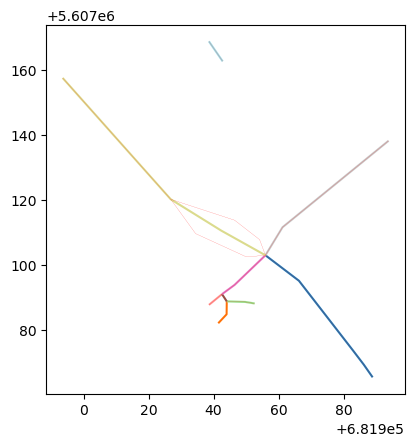

5093


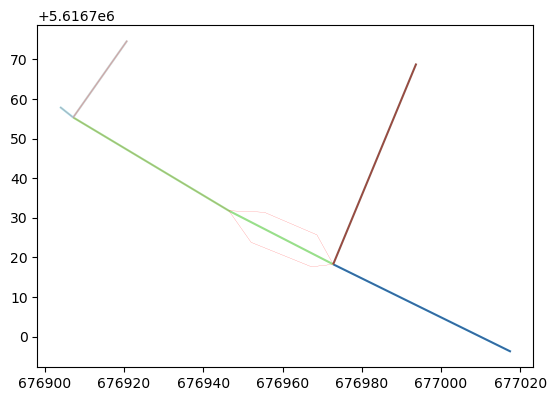

6793


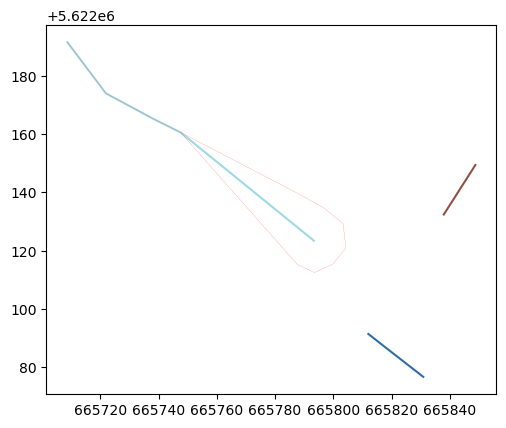

269


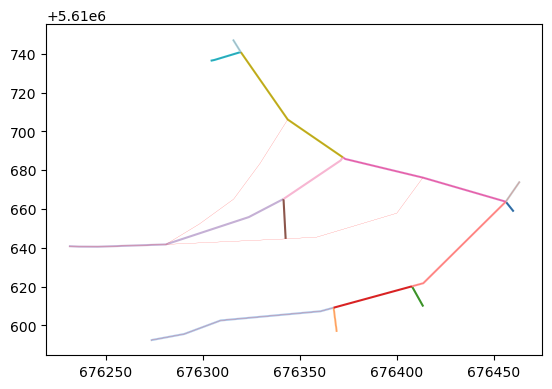

6954


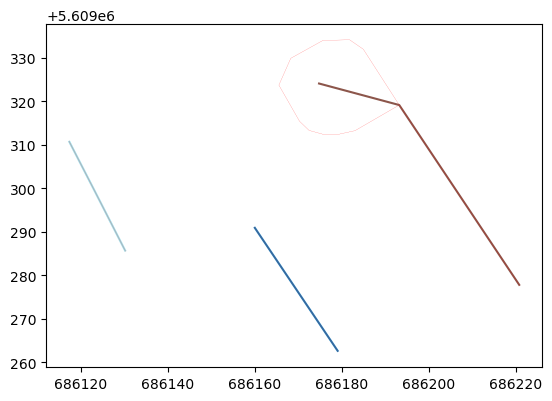

3985


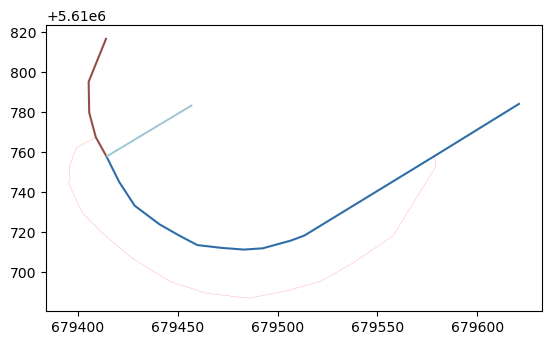

1247


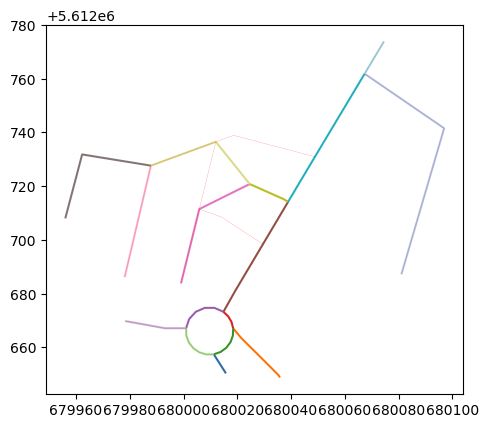

476


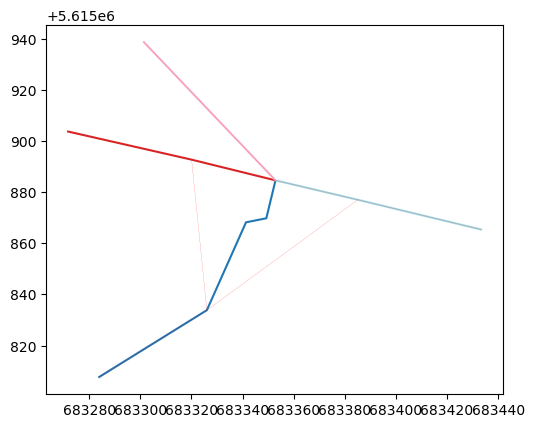

1064


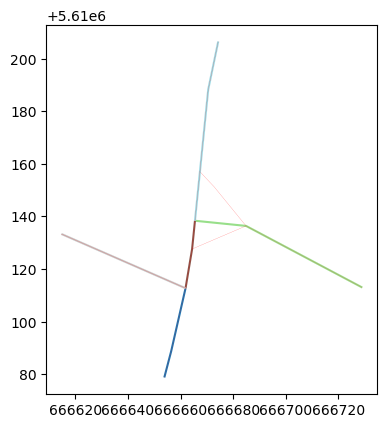

819


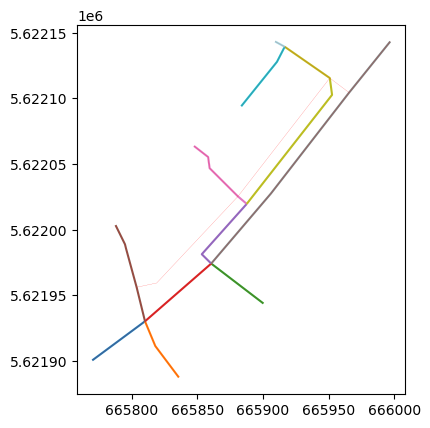

5234


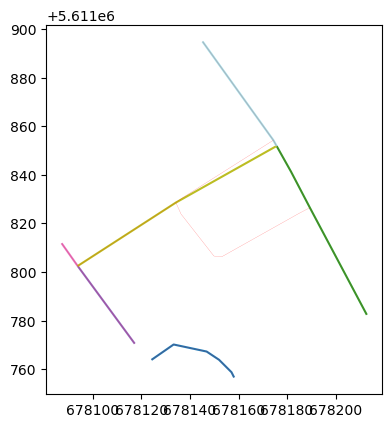

6978


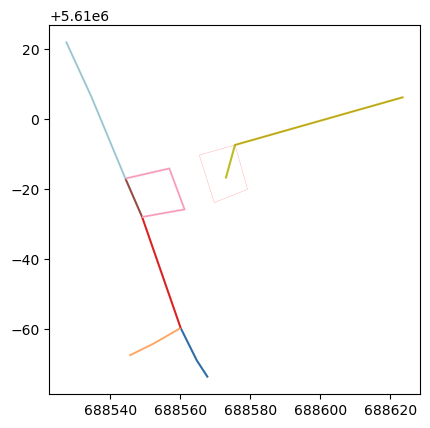

3745


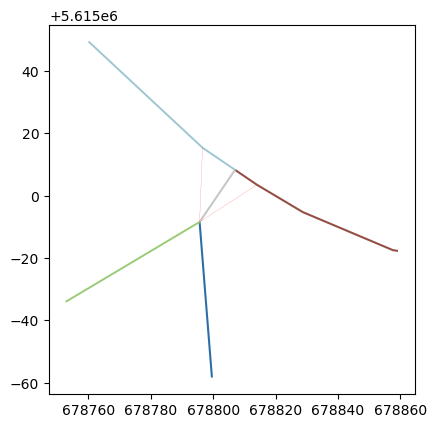

5034


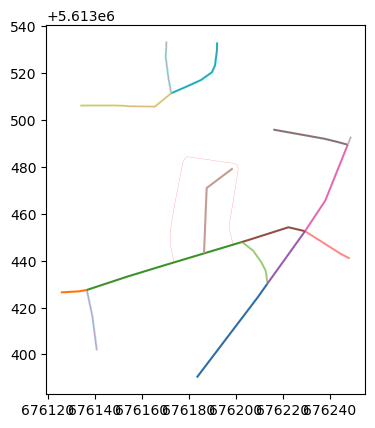

6950


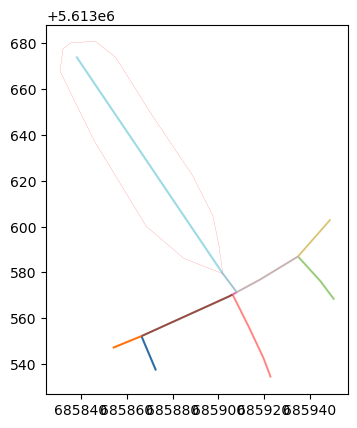

5745


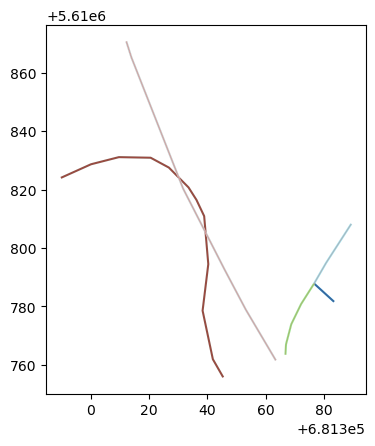

6232


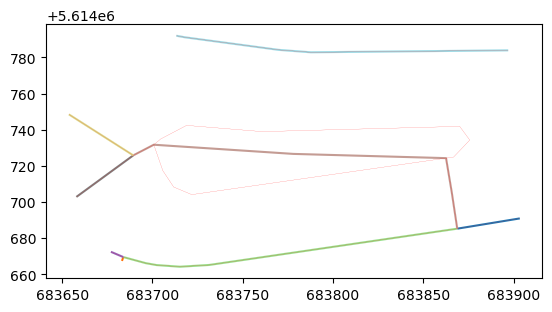

2822


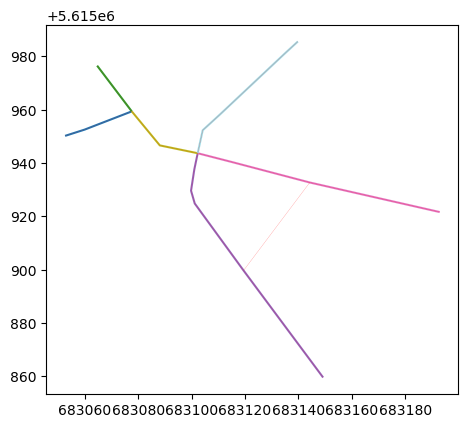

638


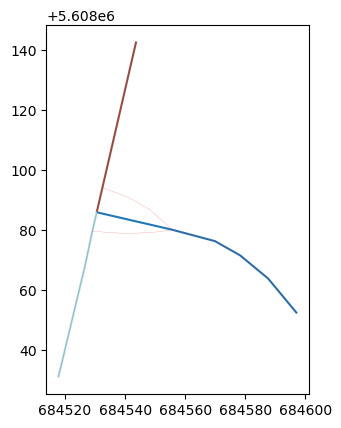

3055


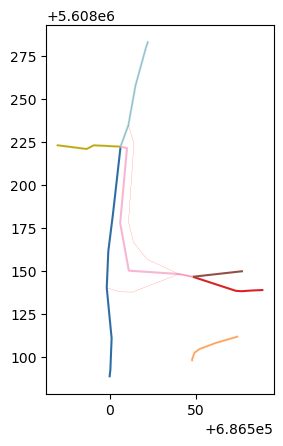

6851


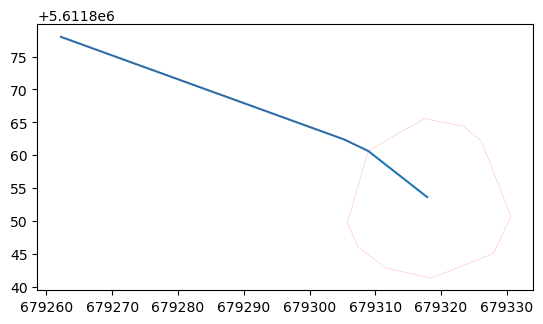

3888


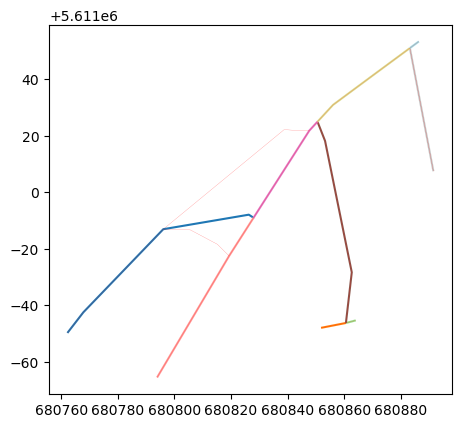

2027


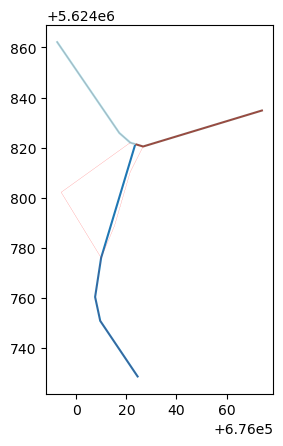

5511


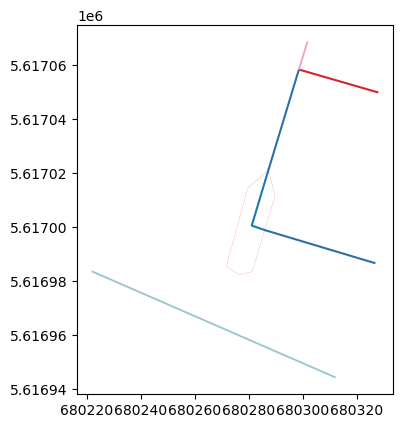

6948


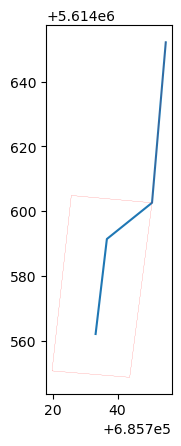

4339


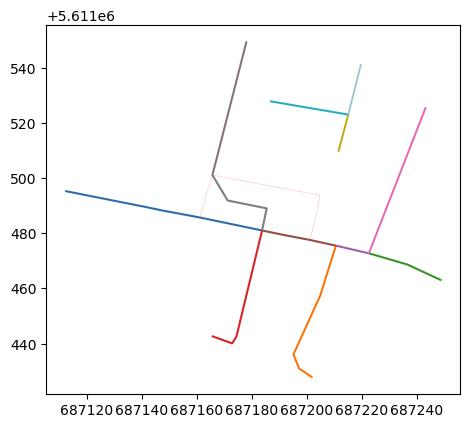

655


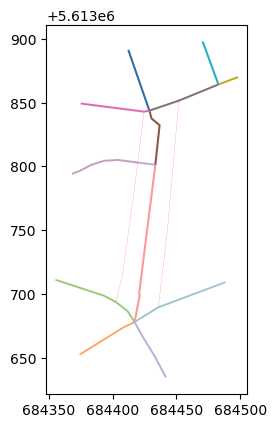

2434


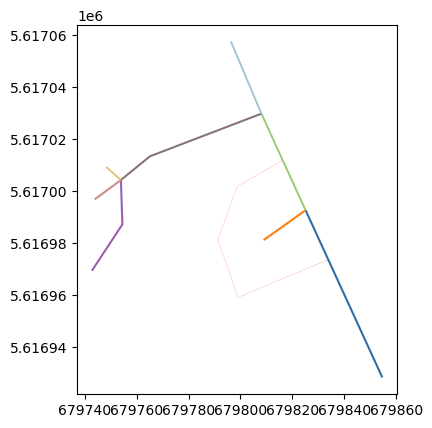

3244


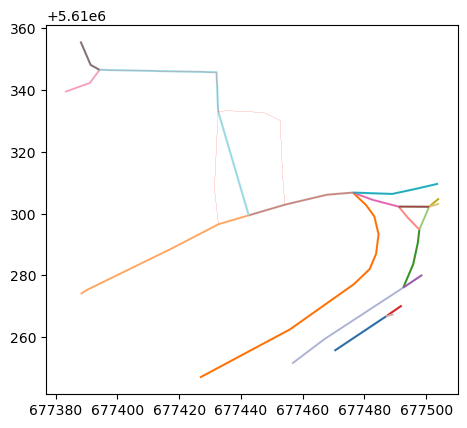

4306


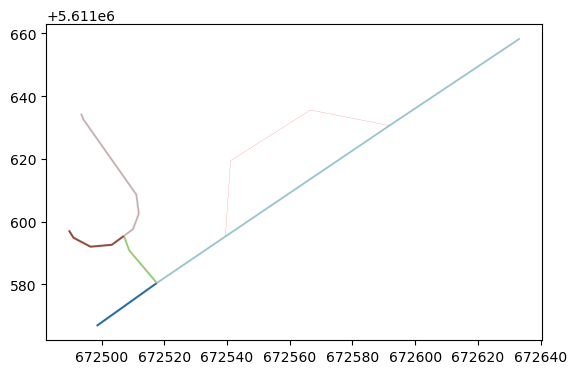

2007


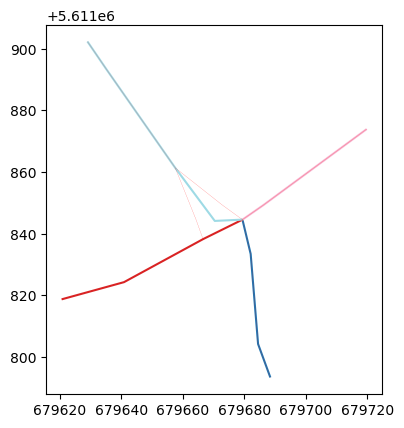

6038


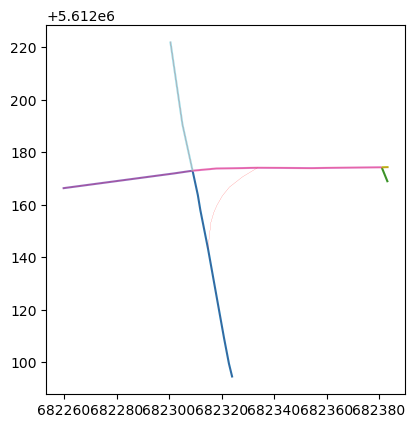

341


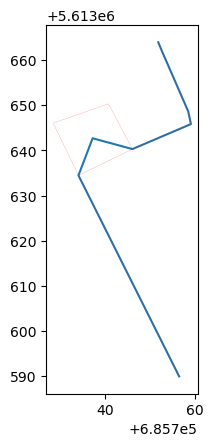

6192


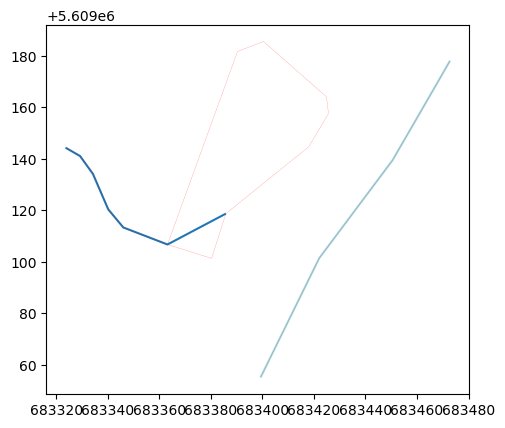

6974


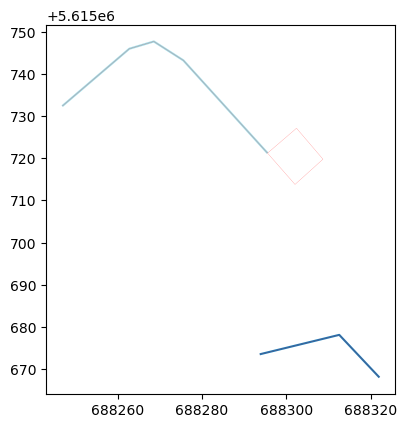

1540


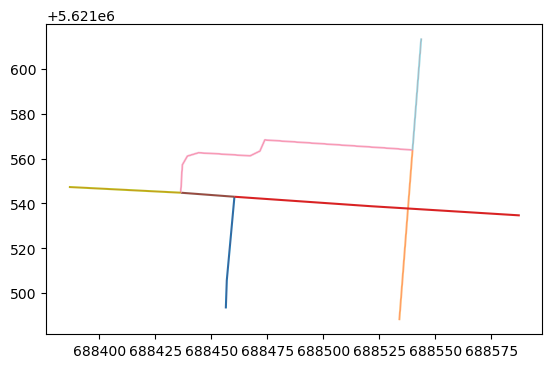

4646


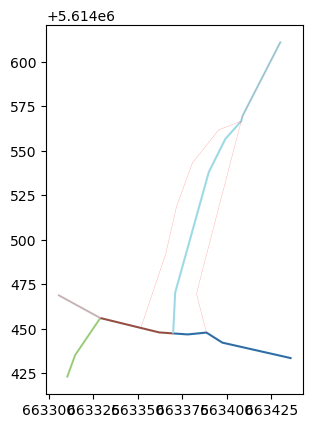

2863


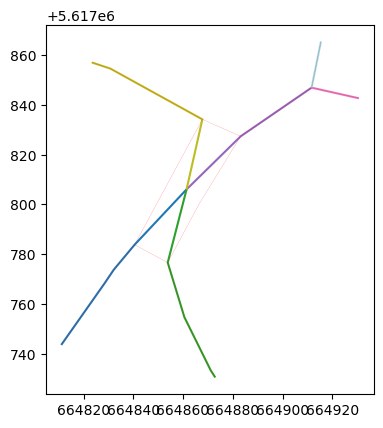

6335


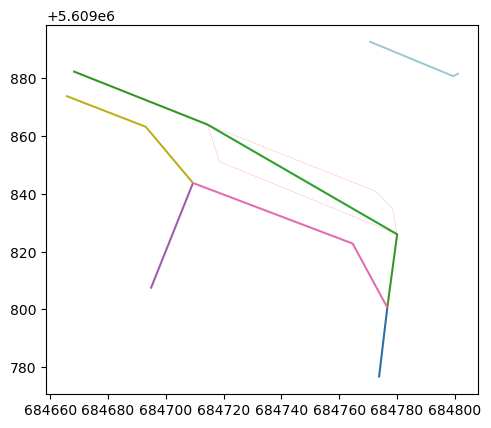

3321


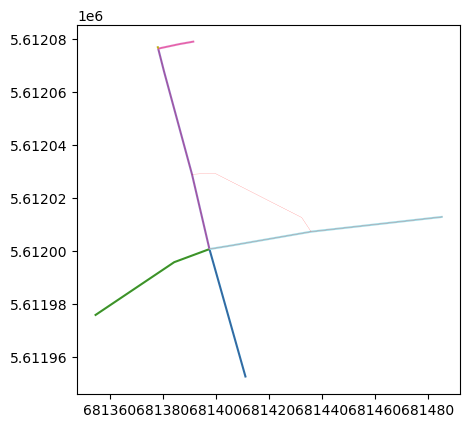

2874


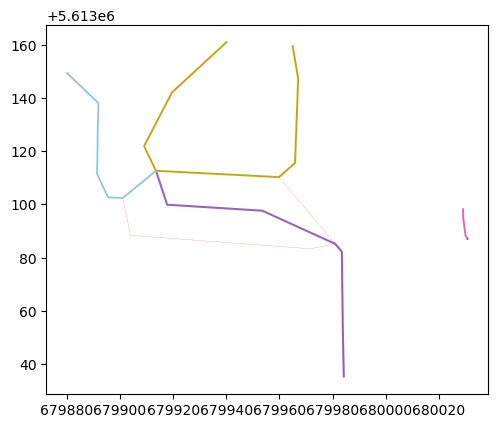

4508


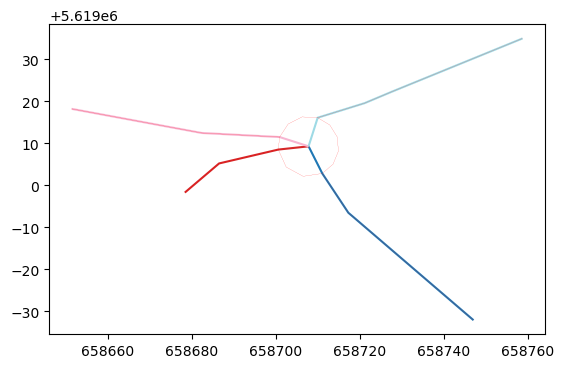

2226


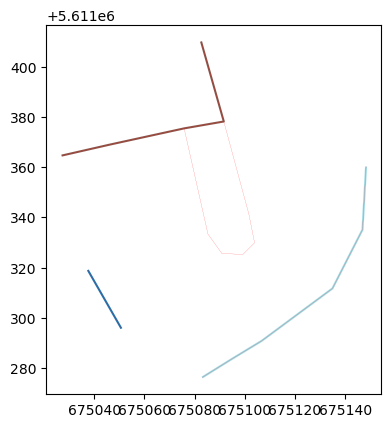

6942


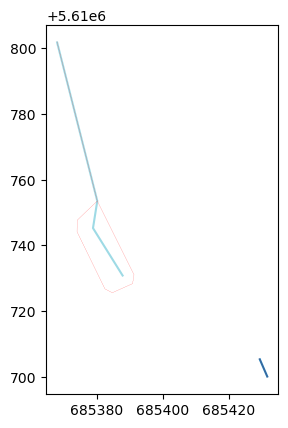

5450


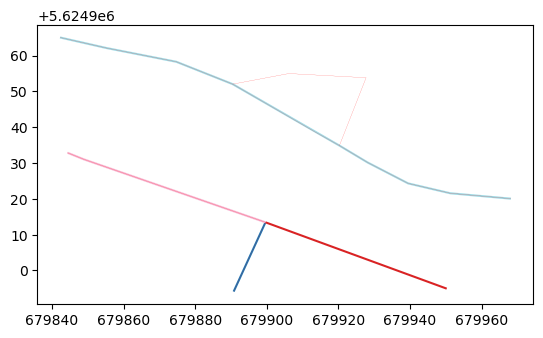

1675


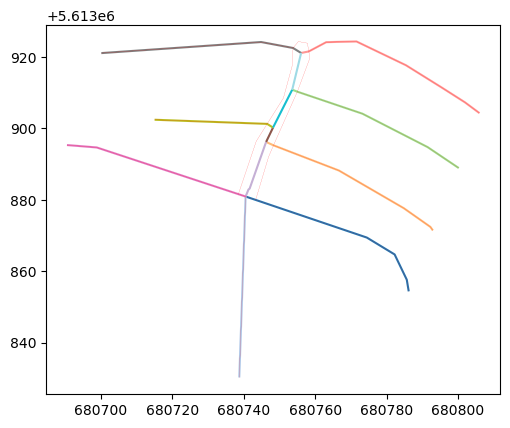

3415


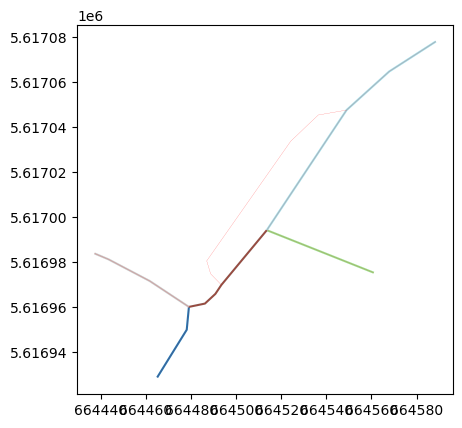

5452


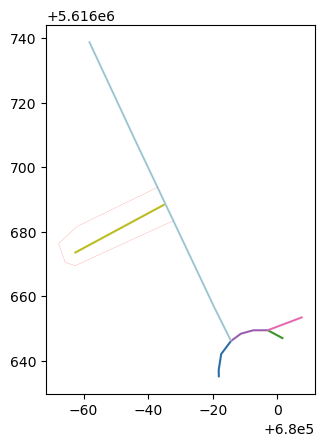

2050


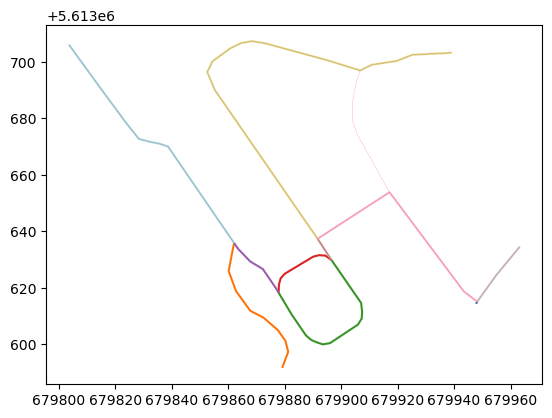

5438


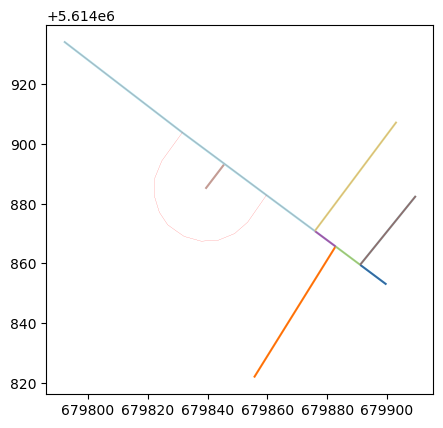

In [11]:
for artifact in data_sample.itertuples():
    print(artifact.Index)

    # plot the results for visual verification
    geom = artifact.geometry
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()